### First experiments with U-Net on RW sst data

Trained model with **variable mask** and **augmentation factor 3** on samples with rel. amount of missing values in the **range of [0, 1]**. 

Now feed validation samples with fixed rel. amount of missing data ([0.999, 0.99, 0.95, 0.90, 0.75, 0.5, 0.25], respectively), that has been used for training final models (*unet_5conv_sst_realworld_variable_discrete_factor_2_final*).

Compare resulting validation loss with validation loss from final models.

In [1]:
import os
import sys
sys.path.append('../reconstruct_missing_data')

from pathlib import Path
from json import dump, load

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from data_loading import find_data_files, load_data_set, get_anomalies, clone_data, create_missing_mask, split_and_scale_data
from models import build_unet_5conv

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511')

In [3]:
# Common parameters for all experiments:
model_config = 'unet_5conv'
feature = 'sea-surface-temperature' # Choose either 'sea-level-pressure' or 'sea-surface-temperature' as feature.
feature_short = 'sst' # Free to set short name, to store results, e.g. 'slp' and 'sst'.
source = 'realworld' # Choose Earth System Model, either 'FOCI' or 'CESM', or 'realworld'.

# Specific parameters for exp3a:
mask_types = ['variable','variable','variable']
missing_types = ['discrete','discrete','discrete']
augmentation_factors = [2,2,2]
runs = ['_seed_1', '_seed_2', '_seed_3']

# Reconstruct path to experiment:
paths = []
for i in range(len(mask_types)):
    paths.append(Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_types[i]+'_'+missing_types[i]+'_factor_'+str(augmentation_factors[i])+runs[i]))
    print(paths[i])

# Initialize storage for parameters of all experiments:
parameters_all = []

# Reload parameters for all experiments:
for path in paths:
    
    # Open corresponding parameter file and store:
    with open(path / 'parameters.json', 'r') as f:
        parameters_all.append(load(f))

# Convert to numpy array:
parameters_all = np.array(parameters_all)

# Extract certain parameters from first experiment. Note: These parameters should be identical for all experiments of interest, here.
train_val_split = parameters_all[0]['train_val_split']
missing_values = parameters_all[0]['missing_values']
scale_to = parameters_all[0]['scale_to']
epochs = parameters_all[0]['epochs']

## Get an overview of final train and validation loss, depending on rel. amount of missing values, for all experiments.
## Note: Start with epoch 0, hence untrained model.

# Initialize storage for final train and validation loss. Dimension: (#experiments, #missing values settings, #epochs+1)
train_loss_final_all = np.zeros((len(paths),len(missing_values),epochs+1))
val_loss_final_all = np.zeros((len(paths),len(missing_values),epochs+1))

# Loop over experiments:
for i in range(len(paths)):
    
    # Get path for current experiment:
    path = paths[i]

    # Loop over array of desired rel. amounts of missing values:
    for j in range(len(missing_values)):

        # Get current sparsity:
        missing = missing_values[j]

        # Reload loss.
        # Rel. amount of missing values = 0.999 requires special treatment:
        if missing==0.999:
            train_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'val_loss.npy')
        else:
            train_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'val_loss.npy')
 
        # Store final train and validation loss:
        train_loss_final_all[i,j,:] = train_loss
        val_loss_final_all[i,j,:] = val_loss
        
# Get minimum train and validation loss over epochs for experiment 3:
train_loss_min_exp3a = np.min(train_loss_final_all,axis=-1)
val_loss_min_exp3a = np.min(val_loss_final_all,axis=-1)

# Get mean and std dev of minimum train and validation loss over all runs:
train_loss_min_mean_exp3a = np.mean(train_loss_min_exp3a,axis=0)
val_loss_min_mean_exp3a = np.mean(val_loss_min_exp3a,axis=0)
train_loss_min_std_exp3a = np.std(train_loss_min_exp3a,axis=0)
val_loss_min_std_exp3a = np.std(val_loss_min_exp3a,axis=0)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_5conv_sst_realworld_variable_discrete_factor_2_seed_1
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_5conv_sst_realworld_variable_discrete_factor_2_seed_2
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_5conv_sst_realworld_variable_discrete_factor_2_seed_3


In [4]:
## Prepare reloading models trained on discrete rel. amounts of missing values:

# Specify experiment:
model_config = 'unet_5conv'
feature = 'sea-surface-temperature' # Choose either 'sea-level-pressure' or 'sea-surface-temperature' as feature.
feature_short = 'sst' # Free to set short name, to store results, e.g. 'slp' and 'sst'.
source = 'realworld' # Choose Earth System Model, either 'FOCI' or 'CESM'.

mask_type = 'variable'
missing_type = 'discrete'
augmentation_factor = 2
run = '_final'

# Get path to stored validation loss from batch:
path_to_final_discrete_model = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run)

print(path_to_final_discrete_model)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_5conv_sst_realworld_variable_discrete_factor_2_final


In [5]:
## Reload train and validation loss from model trained on range:

# Specify experiment:
model_config = 'unet_5conv'
feature = 'sea-surface-temperature' # Choose either 'sea-level-pressure' or 'sea-surface-temperature' as feature.
feature_short = 'sst' # Free to set short name, to store results, e.g. 'slp' and 'sst'.
source = 'realworld' # Choose Earth System Model, either 'FOCI' or 'CESM'.

mask_type = 'variable'
missing_type = 'range'
range_string = '_0_100'
augmentation_factor = 3
run = '_seed_1'

# Get path to stored validation loss from batch:
path = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_type+'_'+missing_type+range_string+'_factor_'+str(augmentation_factor)+run+'/missing'+range_string)


print(path)

# Reload train and validation loss over epochs:
train_loss_range = np.load(path / 'train_loss.npy')
val_loss_range = np.load(path / 'val_loss.npy')

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_5conv_sst_realworld_variable_range_0_100_factor_3_seed_1/missing_0_100


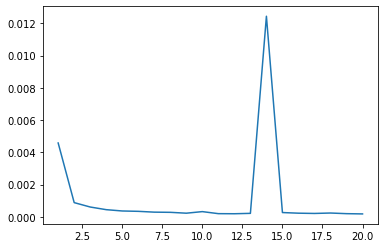

In [6]:
plt.plot(np.arange(1,len(train_loss_range)),train_loss_range[1:]) # Epoch 9 is performing best, saved as 'final' model.

In [7]:
## Reload final model, trained on range:

# Specify experiment:
model_config = 'unet_5conv'
feature = 'sea-surface-temperature' # Choose either 'sea-level-pressure' or 'sea-surface-temperature' as feature.
feature_short = 'sst' # Free to set short name, to store results, e.g. 'slp' and 'sst'.
source = 'realworld' # Choose Earth System Model, either 'FOCI' or 'CESM'.

mask_type = 'variable'
missing_type = 'range'
range_string = '_0_100'
augmentation_factor = 3
run = '_final'

# # Get path to stored validation loss from batch:
# path_to_final_range_model = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/'+model_config+'_'+feature_short+'_'+source+'_'
#                       +mask_type+'_'+missing_type+'_75_99_factor_'+str(augmentation_factor)+run)

# Get path to stored validation loss from batch:
path_to_final_range_model = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_type+'_'+missing_type+range_string+'_factor_'+str(augmentation_factor)+run)

print(path_to_final_range_model)

# Reload parameters for this experiment:
with open(path_to_final_range_model / 'parameters.json', 'r') as f:
    parameters=load(f)

train_val_split = parameters['train_val_split']
missing_values = [0.999, 0.99, 0.95, 0.9, 0.75, 0.5, 0.25] # Manually set, not taken from parameters file, since it contains only the range limits.
scale_to = parameters['scale_to']

# Reload final model, trained on range:
model_filename = 'missing' + range_string + '/model'
model = tf.keras.models.load_model(path_to_final_range_model / model_filename)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_5conv_sst_realworld_variable_range_0_100_factor_3_final


2023-03-09 09:51:56.472340: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2023-03-09 09:51:56.472359: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-09 09:51:56.472370: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (neshcl100): /proc/driver/nvidia/version does not exist
2023-03-09 09:51:56.472529: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# # Load data:

# Set path:
path_to_data = "GitHub/MarcoLandtHayen/reconstruct_missing_data/data/raw/sst.mnmean.nc"  # Full data

# Open data set:
sst_dataset=xr.open_dataset("GitHub/MarcoLandtHayen/reconstruct_missing_data/data/raw/sst.mnmean.nc")

# Start with raw slp fields as lat/lon grids in time, from 1948 to 2022:
sst_fields = (
    sst_dataset.sst
    .sel(time=slice('1880-01-01', '2022-12-01'))
)

# Compute monthly climatology (here 1980 - 2009) for whole world:
sst_climatology_fields = (
    sst_dataset.sst
    .sel(time=slice('1980-01-01','2009-12-01'))
    .groupby("time.month")
    .mean("time")
)

# Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
sst_anomaly_fields = sst_fields.groupby("time.month") - sst_climatology_fields

# Remove last row (latidute) and last 4 columns (longitude), to have even number of steps in latitude (=88)
# and longitude (=176), that can be evenly divided 4 times by two. This serves as 'quick-and-dirty'
# solution to avoid problems with UPSAMPLING in U-Net. There must be a more elegant way, take care of it later!
sst_anomaly_fields = sst_anomaly_fields.values[:,5:-4,:-4]

# !!! Feed range model with data, that has been used to train final discrete model with augmentation factor 2!
augmentation_factor = 2

# Get number of train and validation samples: Consider augmentation factor!
n_train = int(len(sst_anomaly_fields) * augmentation_factor * train_val_split)
n_val = (len(sst_anomaly_fields) * augmentation_factor) - n_train

In [9]:
# Initialize storage for validation inputs: Dimensions (#missing values settings, #val.samples, lat, lon)
val_input_all = np.zeros((len(missing_values), n_val, sst_anomaly_fields.shape[1], sst_anomaly_fields.shape[2]))

# Initialize storage for validation targets: Dimensions (#val.samples, lat, lon)
val_target_all = np.zeros((n_val, sst_anomaly_fields.shape[1], sst_anomaly_fields.shape[2]))

# Initialize storage for validation predictions: Dimensions (#missing values settings, #samples, lat, lon)
val_pred_all = np.zeros((len(missing_values), n_val, sst_anomaly_fields.shape[1], sst_anomaly_fields.shape[2]))

In [10]:
# Loop over rel. amounts of missing values:
for i in range(len(missing_values)):

    # Get status:
    print('missing: ',i+1,' of ',len(missing_values))
    # Get current rel. amount of missing values:
    missing = missing_values[i]

    ## Load complete data, reconstruct sparse data (as inputs) and complete data (as targets).

    # Open data set:
    sst_dataset=xr.open_dataset("GitHub/MarcoLandtHayen/reconstruct_missing_data/data/raw/sst.mnmean.nc")

    # Start with raw slp fields as lat/lon grids in time, from 1948 to 2022:
    sst_fields = (
        sst_dataset.sst
        .sel(time=slice('1880-01-01', '2022-12-01'))
    )

    # Compute monthly climatology (here 1980 - 2009) for whole world:
    sst_climatology_fields = (
        sst_dataset.sst
        .sel(time=slice('1980-01-01','2009-12-01'))
        .groupby("time.month")
        .mean("time")
    )

    # Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
    sst_anomaly_fields = sst_fields.groupby("time.month") - sst_climatology_fields

    # Remove last row (latidute) and last 4 columns (longitude), to have even number of steps in latitude (=88)
    # and longitude (=176), that can be evenly divided 4 times by two. This serves as 'quick-and-dirty'
    # solution to avoid problems with UPSAMPLING in U-Net. There must be a more elegant way, take care of it later!
    sst_anomaly_fields = sst_anomaly_fields.values[:,5:-4,:-4]
    
    # Extend data, if desired:
    data = clone_data(data=sst_anomaly_fields, augmentation_factor=augmentation_factor)

    # Reload mask for missing values.
    # Rel. amount of missing values = 0.999 requires special treatment:
    if missing==0.999:
        missing_mask = np.load(path_to_final_discrete_model / 'missing_' f'{int(missing*1000)}' / 'missing_mask.npy')
    else:
        missing_mask = np.load(path_to_final_discrete_model / 'missing_' f'{int(missing*100)}' / 'missing_mask.npy')

    # Use sparse data as inputs and complete data as targets. Split sparse and complete data into training and validation sets. 
    # Scale or normlalize data according to statistics obtained from only training data.
    _, val_input, _, val_target, train_min, train_max, train_mean, train_std = split_and_scale_data(
        data, 
        missing_mask, 
        train_val_split, 
        scale_to
    )

    # Store inputs: Omit final dimension of predictions, that only contains the channel (here: 1)
    val_input_all[i,:,:,:] = val_input[:,:,:,0]

    # Store targets: Only once!
    if i == 0:
        val_target_all[:,:,:] = val_target[:,:,:]

    # Get model predictions on validation data:
    val_pred = model.predict(val_input_all[i])

    # Store predictions: Omit final dimension of predictions, that only contains the channel (here: 1)
    val_pred_all[i,:,:,:] = val_pred[:,:,:,0]

missing:  1  of  7


2023-03-09 09:53:59.783893: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


missing:  2  of  7
missing:  3  of  7
missing:  4  of  7
missing:  5  of  7
missing:  6  of  7
missing:  7  of  7


In [11]:
# ## Compute validation loss for model trained on range, feeding samples with discrete rel. amount of missing values:

# # Initialize storage for validation loss for all rel. amounts of missing values. 
# # Dimensions (#missing values settings):
# val_loss_all = np.zeros(len(missing_values))

# # Loop over rel. amounts of missing values:
# for i in range(len(missing_values)):
    
#     # Compute and store validation loss:
#     val_loss_all[i] = np.mean((val_target_all - val_pred_all[i,:,:,:])**2)        

# # Save validation loss:
# np.save(path_to_final_range_model / 'val_loss_all.npy', val_loss_all)

In [8]:
## Or reload validation loss:
# val_loss_all = np.load(path_to_final_range_model / 'val_loss_all.npy')

In [ ]:
# Plot val_loss_final (red) and val_loss_all (grey) over missing values, as in sensitivity experiment

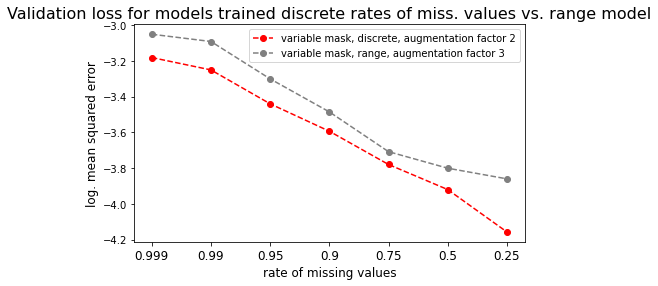

In [12]:
### Result from range experiment with model trained on [0.0,1.0] with augmentation factor 3:

## Plot validation loss over rel. amounts of missing values 
## for final models trained on discrete amounts of missing values (red)
## compared to model trained on range of missing values, 
## but fed with samples of discrete amounts of missing values (grey).

fig, ax = plt.subplots(1,1,figsize=(7,4))

# Validation loss, using final models trained on discrete amounts of missing values (red):
ax.plot(np.log10(val_loss_min_mean_exp3a), color='red',
             label = 'variable mask, discrete, augmentation factor 2',
             marker = 'o', linestyle = '--',
    )

# Final validation loss from model trained on range, but fed with samples of discrete amounts of missing values (grey):
ax.plot(np.log10(val_loss_all), color='grey',
             label = 'variable mask, range, augmentation factor 3',
             marker = 'o', linestyle = '--',
    )

ax.set_xticks(np.arange(0, len(missing_values), step=1), missing_values, fontsize=12)
ax.set_title('Validation loss for models trained discrete rates of miss. values vs. range model', fontsize=16)
ax.set_xlabel('rate of missing values', fontsize=12)
ax.set_ylabel('log. mean squared error', fontsize=12)
ax.legend()
plt.show() 